03_finetuning_resnet.ipynb
- Load dataloaders
- Load ResNet
- Train loop
- Validation loop
- Save best model
- Test accuracy & metrics


In [1]:
import pandas as pd

train_df = pd.read_csv("CSV/plantvillage_train.csv")
val_df   = pd.read_csv("CSV/plantvillage_val.csv")
test_df  = pd.read_csv("CSV/plantvillage_test.csv")

print("Train label counts:")
print(train_df["label"].value_counts())
print("\nValidation label counts:")
print(val_df["label"].value_counts())
print("\nTest label counts:")
print(test_df["label"].value_counts())


Train label counts:
label
0    1777
1    1582
Name: count, dtype: int64

Validation label counts:
label
0    381
1    339
Name: count, dtype: int64

Test label counts:
label
0    381
1    339
Name: count, dtype: int64


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load pretrained model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# 2. Replace final layer (fc) to output 2 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)

# 3. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [3]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torchvision.transforms as T

class PlantBinaryDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]
        label = int(row["label"])

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# same transforms as notebook 02
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# load datasets
train_dataset = PlantBinaryDataset("CSV/plantvillage_train.csv", transform=train_transform)
val_dataset   = PlantBinaryDataset("CSV/plantvillage_val.csv",   transform=val_transform)
test_dataset  = PlantBinaryDataset("CSV/plantvillage_test.csv",  transform=val_transform)

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=0)



In [4]:
import time
import copy
import torch

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, device="cpu"):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                batch_size = inputs.size(0)
                running_loss += loss.item() * batch_size
                running_corrects += torch.sum(preds == labels).item()
                total_samples += batch_size

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)

                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed/60:.1f} min")
    print(f"Best val Acc: {best_val_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, history

In [5]:
num_epochs = 10

model, history = train_model(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    num_epochs=num_epochs,
    device=device,
)



Epoch 1/10
------------------------------
train Loss: 0.0586 Acc: 0.9759
val Loss: 0.0159 Acc: 0.9958

Epoch 2/10
------------------------------
train Loss: 0.0082 Acc: 0.9973
val Loss: 0.0056 Acc: 0.9986

Epoch 3/10
------------------------------
train Loss: 0.0044 Acc: 0.9985
val Loss: 0.0040 Acc: 0.9986

Epoch 4/10
------------------------------
train Loss: 0.0024 Acc: 0.9988
val Loss: 0.0006 Acc: 1.0000

Epoch 5/10
------------------------------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.0012 Acc: 1.0000

Epoch 6/10
------------------------------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.0003 Acc: 1.0000

Epoch 7/10
------------------------------
train Loss: 0.0071 Acc: 0.9976
val Loss: 0.0058 Acc: 0.9986

Epoch 8/10
------------------------------
train Loss: 0.0068 Acc: 0.9976
val Loss: 0.0025 Acc: 1.0000

Epoch 9/10
------------------------------
train Loss: 0.0080 Acc: 0.9970
val Loss: 0.0153 Acc: 0.9958

Epoch 10/10
------------------------------
train Loss: 0.0010 Acc: 1.000

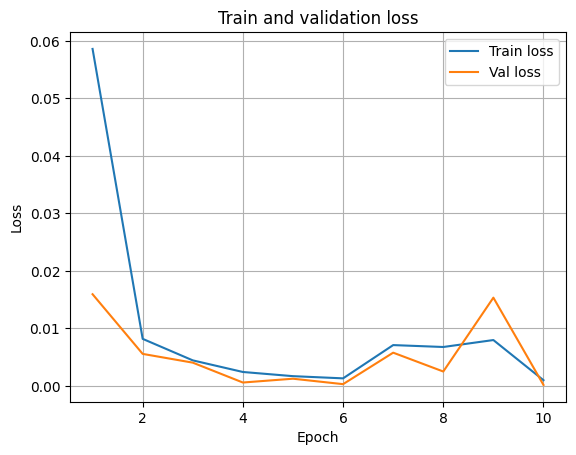

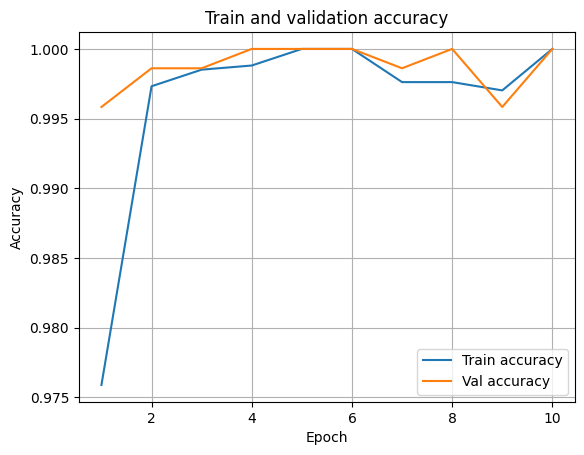

In [6]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and validation loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, history["train_acc"], label="Train accuracy")
plt.plot(epochs, history["val_acc"], label="Val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and validation accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
def evaluate_on_test(model, test_loader, device="cpu"):
    model.eval()
    running_corrects = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels).item()
            total_samples += inputs.size(0)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    test_acc = running_corrects / total_samples
    print(f"Test accuracy: {test_acc:.4f}")

    return all_labels, all_preds

labels, preds = evaluate_on_test(model, test_loader, device=device)


Test accuracy: 0.9972


In [8]:
import pandas as pd

train_df = pd.read_csv("CSV/plantvillage_train.csv")
val_df   = pd.read_csv("CSV/plantvillage_val.csv")
test_df  = pd.read_csv("CSV/plantvillage_test.csv")

summary_table = pd.DataFrame({
    "Split": ["Train", "Validation", "Test"],
    "Healthy (0)": [
        train_df["label"].value_counts().get(0, 0),
        val_df["label"].value_counts().get(0, 0),
        test_df["label"].value_counts().get(0, 0),
    ],
    "Diseased (1)": [
        train_df["label"].value_counts().get(1, 0),
        val_df["label"].value_counts().get(1, 0),
        test_df["label"].value_counts().get(1, 0),
    ],
    "Total Samples": [
        len(train_df), len(val_df), len(test_df)
    ]
})

summary_table.style.set_properties(**{"text-align": "center"}) \
                   .set_table_styles([{
                       "selector": "th",
                       "props": [("text-align", "center")]
                   }])



,Split,Healthy (0),Diseased (1),Total Samples
0,Train,1777,1582,3359
1,Validation,381,339,720
2,Test,381,339,720


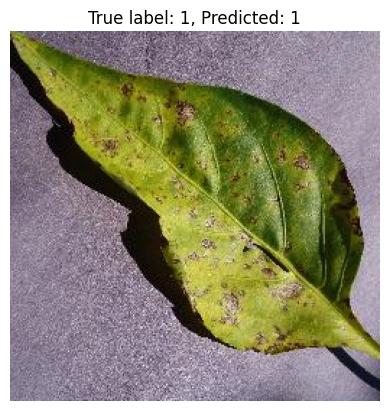

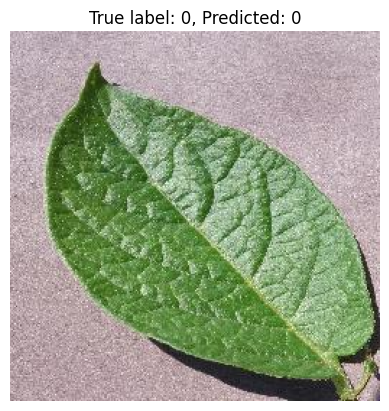

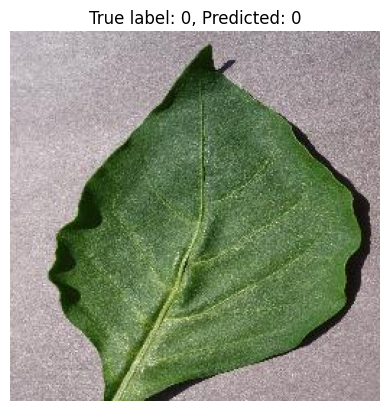

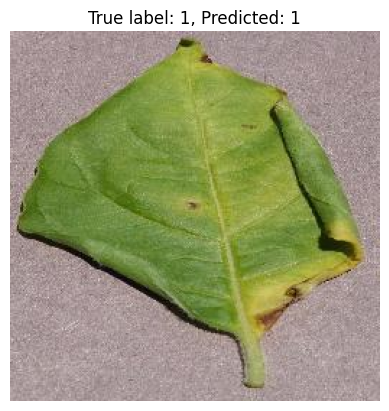

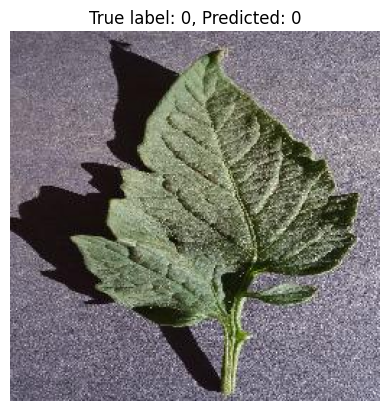

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

test_df = pd.read_csv("CSV/plantvillage_test.csv")

for _ in range(5):
    row = test_df.sample(1).iloc[0]
    img = Image.open(row["image_path"]).convert("RGB")

    x = val_transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        out = model(x)
        pred = out.argmax(dim=1).item()

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True label: {row['label']}, Predicted: {pred}")
    plt.show()
